In [1]:
%load_ext autoreload
%autoreload 2

%cd ..

/Users/rubenbroekx/Documents/Projects/agoro-field-boundary-detector


# Data Augmentation

Perform data augmentation on the annotated field-data in order to create more training data.

In [33]:
import json
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from pathlib import Path

from src.agoro_field_boundary_detector.data import load_annotations, polygons_to_mask, transform
from src.agoro_field_boundary_detector.data.transformations import t_linear, t_quartile, t_rotation, t_flip, t_blur, t_gamma
from src.agoro_field_boundary_detector.augment_data import _get_transformation

## Data

Load in the (example) image together with its corresponding annotations.

In [34]:
# Image to load
NAME = '41.481412--88.842236'

In [37]:
# Load in the annotations
annotations = load_annotations(Path.cwd() / 'data/annotations.json')
boundaries = annotations[NAME]

In [15]:
# Load in field and mask
field = np.asarray(Image.open(Path.cwd() / f"data/raw/{NAME}.png"))
mask = polygons_to_mask(boundaries)

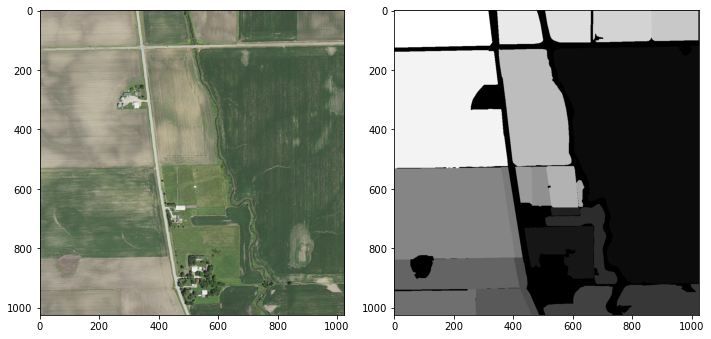

In [16]:
def show_image(field:np.ndarray, mask:np.ndarray):
    """Show the field and corresponding mask."""
    fig = plt.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121)  # left side
    ax2 = fig.add_subplot(122)  # right side
    ax1.imshow(field)
    plt.gray()
    ax2.imshow(mask)
    plt.tight_layout()
    plt.show()
    
show_image(field, mask)

## Transformations

Apply the different transformation and visualise the result.

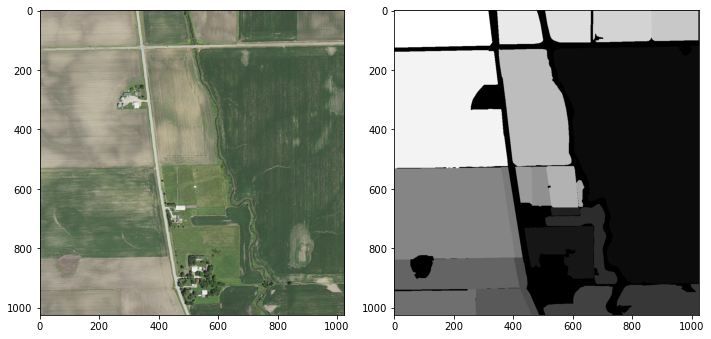

In [17]:
f,m = t_linear(field, mask)
show_image(f,m)

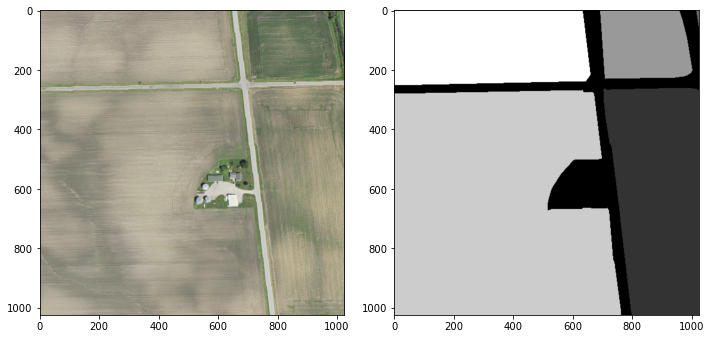

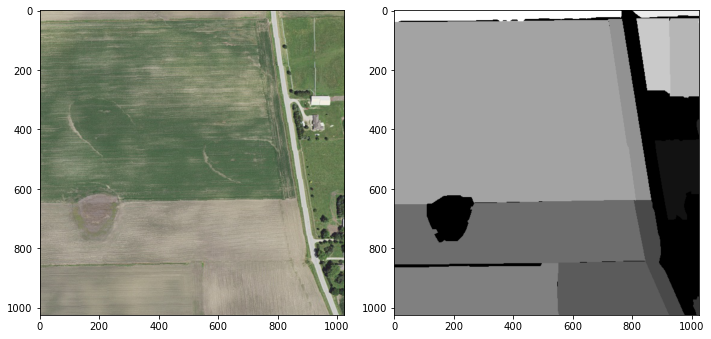

In [18]:
for idx in (0, 2):
    f,m = t_quartile(field, mask, idx=idx)
    show_image(f,m)

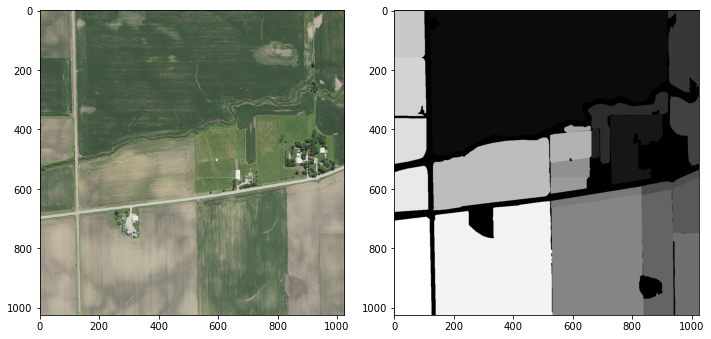

In [19]:
f,m = t_rotation(field, mask, rot=1)
show_image(f,m)

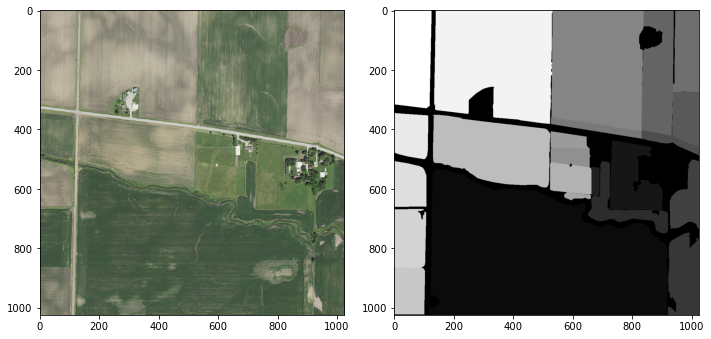

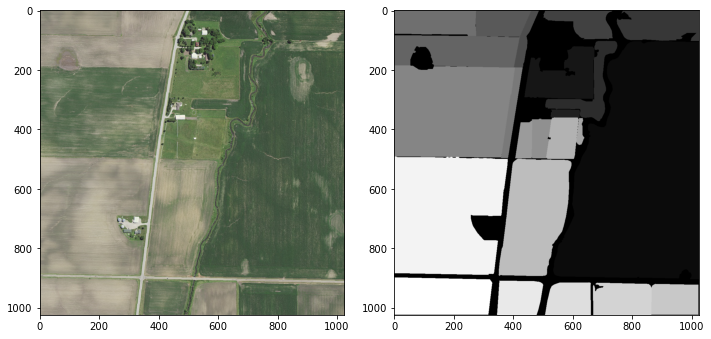

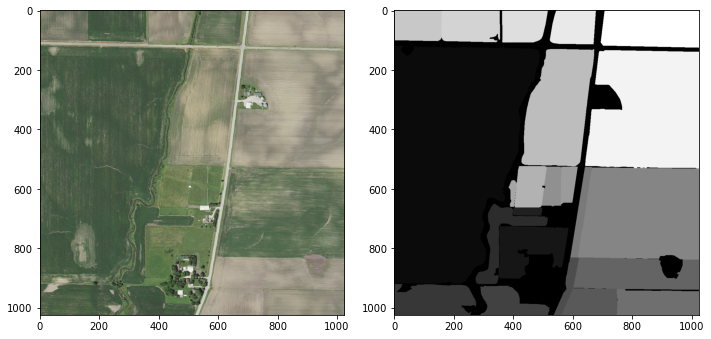

In [20]:
for idx in (0,1,2):
    f,m = t_flip(field, mask, idx=idx)
    show_image(f,m)

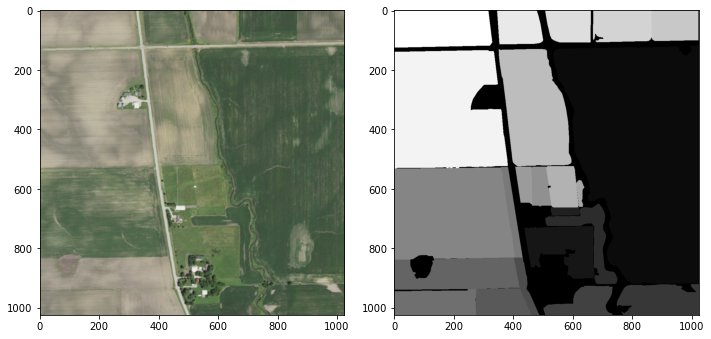

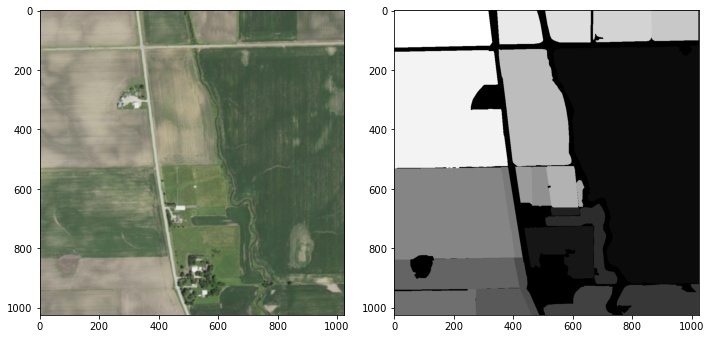

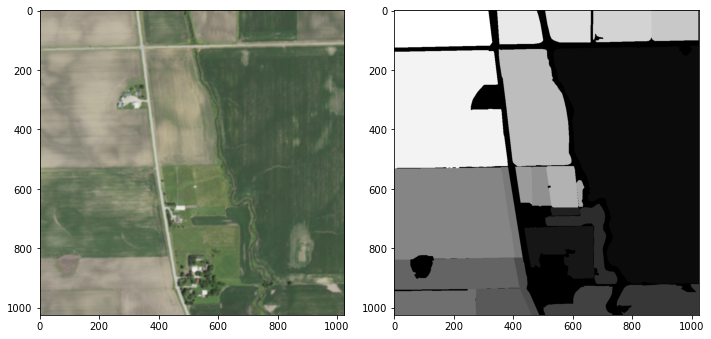

In [21]:
for sigma in (1, 5, 10):
    f,m = t_blur(field, mask, sigma=sigma)
    show_image(f,m)

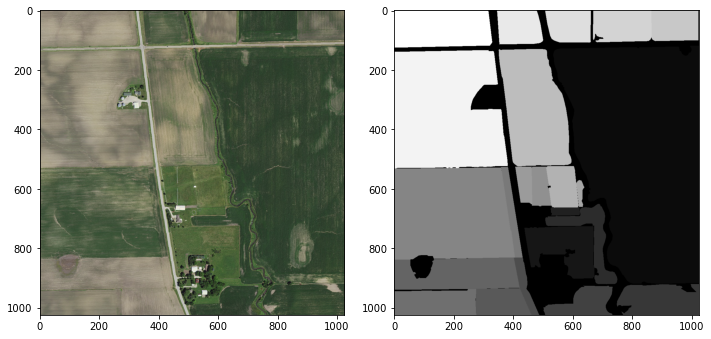

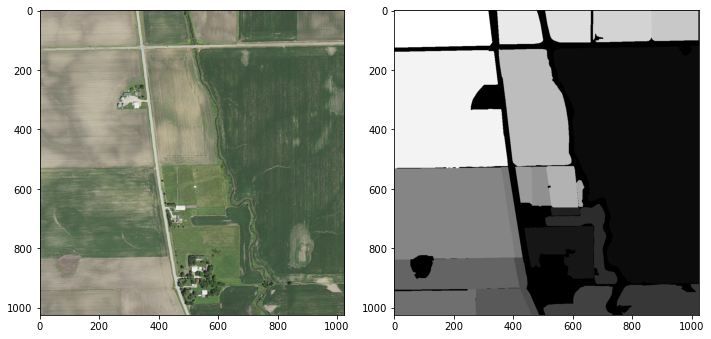

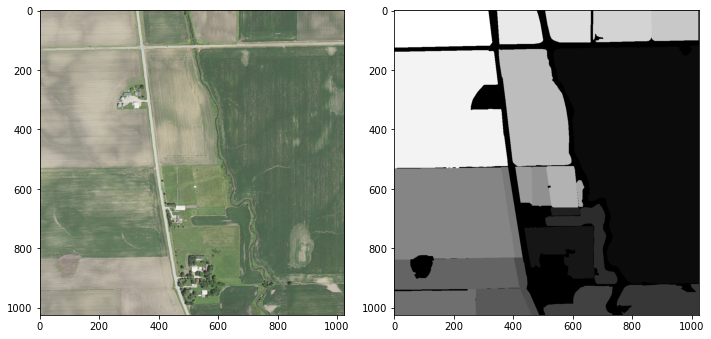

In [22]:
for gamma in (8, 10, 12):
    f,m = t_gamma(np.copy(field), mask, gamma=gamma)
    show_image(f,m)

## Randomised transformation

Generate randomised transformation that applies both:
 - Translation: `t_linear`, `t_quartile`, `t_offset`
 - Noise: `t_linear`, `t_rotation`, `t_flip`, `t_blur`, `t_gamma`

t_linear with idx 0  and  t_rotation with idx 3


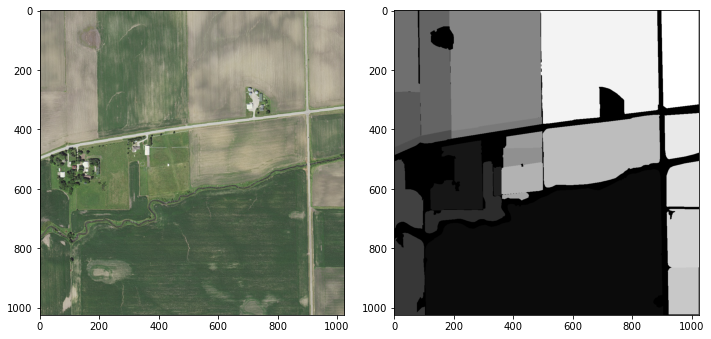

t_quartile with idx 3  and  t_rotation with idx 2


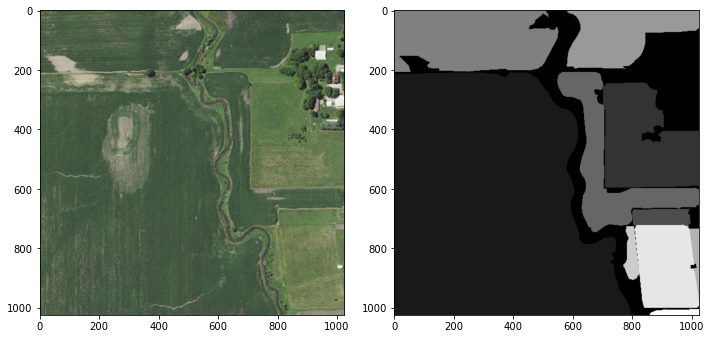

t_quartile with idx 1  and  t_flip with idx 0


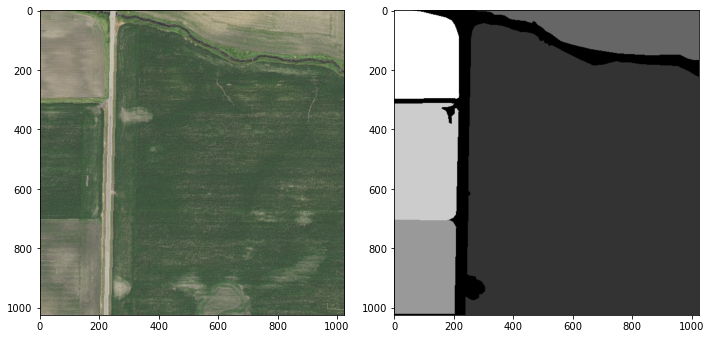

t_linear with idx 0  and  t_rotation with idx 0


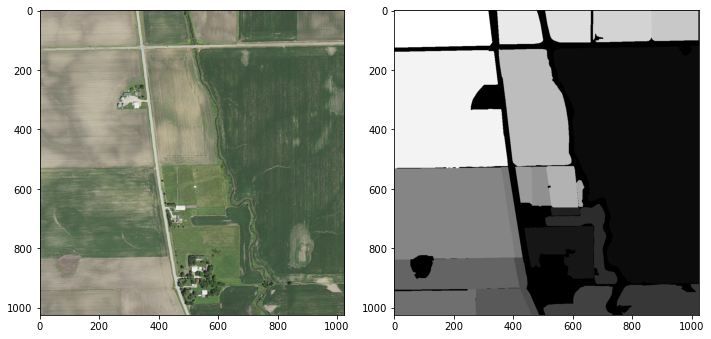

t_linear with idx 0  and  t_linear with idx 0


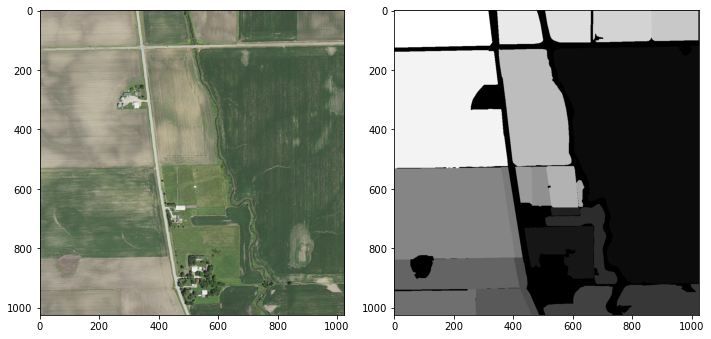

t_quartile with idx 0  and  t_rotation with idx 1


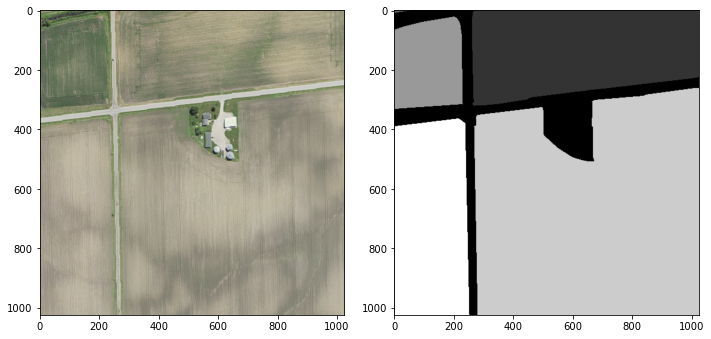

t_quartile with idx 1  and  t_rotation with idx 1


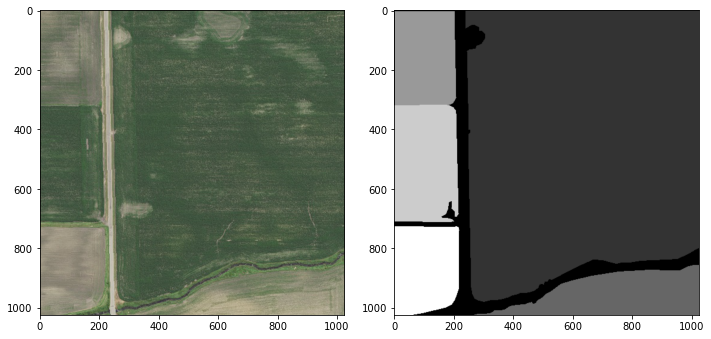

t_quartile with idx 3  and  t_rotation with idx 3


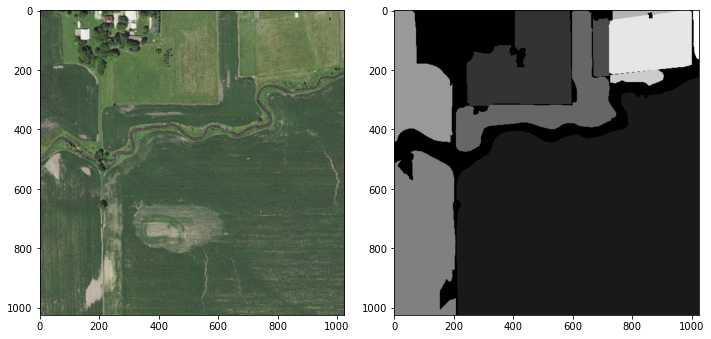

t_linear with idx 0  and  t_gamma with idx 8


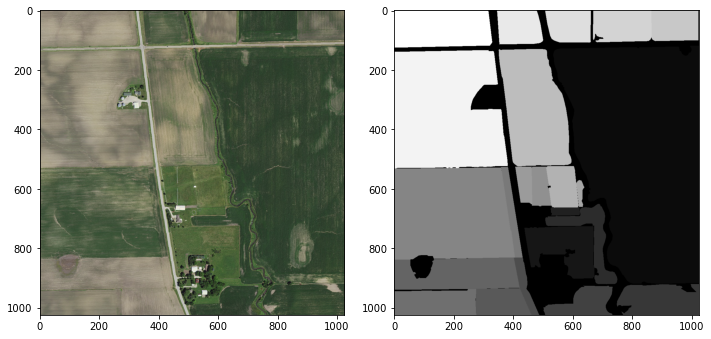

t_linear with idx 0  and  t_flip with idx 0


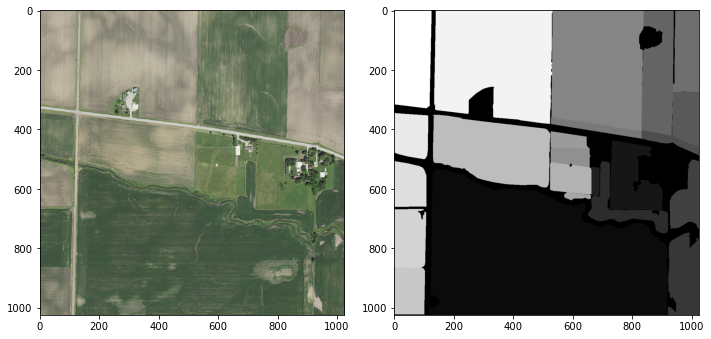

In [23]:
for _ in range(10):
    transformation = _get_transformation()
    print(f"{transformation[0].__name__} with idx {transformation[1]}  and  {transformation[2].__name__} with idx {transformation[3]}")
    field_t, mask_t = transform(
            field=field,
            mask=mask,
            translation=transformation[0],
            t_idx=transformation[1],
            noise=transformation[2],
            n_idx=transformation[3],
    )
    show_image(field_t, mask_t)

# Create Augmented Data

Run the script found under `augment_data.py`.

In [2]:
from src.agoro_field_boundary_detector.augment_data import main

In [ ]:
DATA_PATH = Path.cwd() / "data"

In [ ]:
# Load in the requested coordinates, keep only training
with open(DATA_PATH / "coordinates.json", "r") as f:
    coordinates = json.load(f)
coordinate_names = [f"{c[0]}-{c[1]}" for c in coordinates["train"]]
names = [k for k in annotations.keys() if k in coordinate_names]
len(names)

In [ ]:
# Load in fields and corresponding masks
annotated_fields, annotated_masks = [], []
for name in names:
    annotated_fields.append(np.asarray(Image.open(DATA_PATH / f"raw/{name}.png")))
    annotated_masks.append(polygons_to_mask(annotations[name]))

In [ ]:
# Ensure folders exist
(DATA_PATH / "augmented/fields").mkdir(exist_ok=True, parents=True)
(DATA_PATH / "augmented/masks").mkdir(exist_ok=True, parents=True)

In [ ]:
# Export the given coordinates
main(
    fields=annotated_fields,
    masks=annotated_masks,
    prefixes=names,
    write_folder=DATA_PATH / "augmented",
)

In [ ]:
# Write test-data as-is
(DATA_PATH / "test/fields").mkdir(exist_ok=True, parents=True)
(DATA_PATH / "test/masks").mkdir(exist_ok=True, parents=True)
test_coordinate_names = [f"{c[0]}-{c[1]}" for c in coordinates["test"]]
test_names = [k for k in annotations.keys() if k in test_coordinate_names]
len(test_names)

In [ ]:
for name in test_names:
    field = np.asarray(Image.open(DATA_PATH / f"raw/{name}.png"))
    mask = polygons_to_mask(annotations[name])
    with open(DATA_PATH / f"test/fields/{name}.npy", "wb") as f:  # type: ignore
        np.save(f, field)
    with open(DATA_PATH / f"test/masks/{name}.npy", "wb") as f:  # type: ignore
        np.save(f, mask)